In [ ]:
# TODO use intercept?

In [14]:
%pylab inline
import statsmodels.api as sm
import pandas as pd

df = pd.read_csv("/storage/s1saini/dbgap_estr_analysis_sept18/sampleid_smtag_info_str_snp.txt", sep="\t")
df["snp.gt"] = df["SNP"].apply(lambda x: sum([int(item) for item in x.split("/")]))
df["pt"] = df["PHENO"].apply(lambda x: 1 if x=="Yes" else 0)

Populating the interactive namespace from numpy and matplotlib


In [25]:
# SNP frequency in cases/controls
print( np.sum(df[df["pt"]==1]["snp.gt"])/(df[df["pt"]==1].shape[0]*2))
print( np.sum(df[df["pt"]==0]["snp.gt"])/(df[df["pt"]==0].shape[0]*2))

0.6615853658536586
0.7086614173228346


In [41]:
# Check for SNP association
data = df[["pt","snp.gt"]]
data["intercept"] = 1.0

logit = sm.Logit(data["pt"], data[["intercept","snp.gt"]])
result = logit.fit()
print(np.exp(result.params["snp.gt"]))
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.507042
         Iterations 5
0.8000755883632112
                           Logit Regression Results                           
Dep. Variable:                     pt   No. Observations:                  611
Model:                          Logit   Df Residuals:                      609
Method:                           MLE   Df Model:                            1
Date:                Tue, 25 Sep 2018   Pseudo R-squ.:                0.003660
Time:                        16:01:41   Log-Likelihood:                -309.80
converged:                       True   LL-Null:                       -310.94
                                        LLR p-value:                    0.1314
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6534      0.232      7.119      0.000       1.198       2.109
snp.gt    

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [44]:
df = df[df["STR"]!="."]
df["str.dosage"] = df["STR"].apply(lambda x: sum([int(item) for item in x.split("|")]))

data = df[["pt","str.dosage"]]
data["intercept"] = 1.0

logit = sm.Logit(data["pt"], data[["intercept","str.dosage"]])
result = logit.fit()
print(np.exp(result.params["str.dosage"]))
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.508861
         Iterations 5
1.0052343116158222
                           Logit Regression Results                           
Dep. Variable:                     pt   No. Observations:                  611
Model:                          Logit   Df Residuals:                      609
Method:                           MLE   Df Model:                            1
Date:                Tue, 25 Sep 2018   Pseudo R-squ.:               8.471e-05
Time:                        16:02:15   Log-Likelihood:                -310.91
converged:                       True   LL-Null:                       -310.94
                                        LLR p-value:                    0.8185
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3292      0.128     10.346      0.000       1.077       1.581
str.dosage

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Ks_2sampResult(statistic=0.017607592865324873, pvalue=1.0)


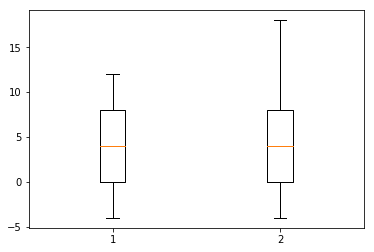

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
casedata = list(df[df["pt"]==1]["str.dosage"])
ctrldata = list(df[df["pt"]==0]["str.dosage"])
strdata = [ctrldata, casedata]
ax.boxplot(strdata);
import scipy.stats
print(scipy.stats.ks_2samp(casedata, ctrldata))

-2 0.9489247311827957 0.2700490998363339
0 0.7122416534181241 0.07201309328968904
2 1.2583554376657826 0.4001636661211129
4 0.7288786482334869 0.020458265139116204
6 0.974025974025974 0.22585924713584288
8 None 0.007364975450081833
10 None 0.0016366612111292963
12 None 0.0024549918166939444


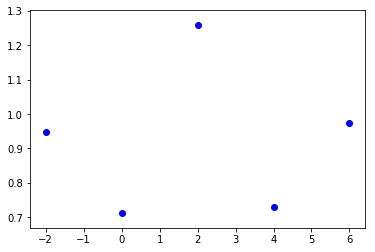

In [88]:
# For each STR allele, get odds ratio
alleles = set()
for i in range(df.shape[0]):
    strgt = df["STR"].values[i].split("|")
    for item in strgt: alleles.add(int(item))

def GetAlleleGT(x, a):
    strgt = [int(int(item)==a) for item in x.split("|")]
    return sum(strgt)


# http://bioinformatics.org.au/ws09/presentations/Day3_JStankovich.pdf
def GetOdds(df, pcount=0):
    # use allele.gt and pt to get odds ratio
    r = []
    s = []
    for i in range(3):
        r.append(df[(df["pt"]==1) & (df["allele.gt"]==i)].shape[0])
        s.append(df[(df["pt"]==0) & (df["allele.gt"]==i)].shape[0])

    # pseudocount
    r = [item+pcount for item in r]
    s = [item+pcount for item in s]
    obs = [[2*r[0]+r[1], r[1]+2*r[2]], [2*s[0]+s[1], s[1]+2*s[2]]]
    
    R = sum(r)
    S = sum(s)
    N = R+S
    n = [s[i]+r[i] for i in range(3)]
    exp = [[2*R*(2*n[0]+n[1])/(2*N), 2*R*(n[1]+2*n[2])/(2*N)], \
           [2*S*(2*n[0]+n[1])/(2*N), 2*S*(n[1]+2*n[2])/(2*N)]]
    
    chisq = 0
    for i in range(2):
        for j in range(2):
            chisq += (obs[i][j]-exp[i][j])**2/exp[i][j]
    
    try:
        odds = (obs[0][0]/obs[1][0])/(obs[0][1]/obs[1][1])
    except ZeroDivisionError: odds = None
    return odds, 1 - scipy.stats.chi2.cdf(chisq, 1)

alleles = sorted(list(alleles))
all_odds = []
all_odds_thresh = []
freqs = []
for a in sorted(list(alleles)):
    df["allele.gt"] = df["STR"].apply(lambda x: GetAlleleGT(x, a), 1)
    freq = np.sum(df["allele.gt"])/(df.shape[0]*2)
    odds, p = GetOdds(df, pcount=0)
    all_odds.append(odds)
    print("%s %s %s"%(a, odds, freq))
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(alleles, all_odds, color="blue")

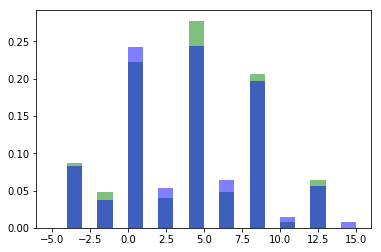

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
bins = np.arange(-5, 16, 1)
ax.hist(df[df["pt"]==0]["str.dosage"],alpha=0.5, bins=bins, normed=True, color="green");
ax.hist(df[df["pt"]==1]["str.dosage"],alpha=0.5, bins=bins, normed=True, color="blue");